<a href="https://colab.research.google.com/github/uc2045/genai-projects/blob/master/030925_Augmented_LLM_with_Tools_March2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build an Augmented LLM with Tools in LangGraph

We already know Tools help the LLM interact with external sources of information like web search

Augmented LLM with Search Tool: Here we will build a simple augmented LLM using the capabilities of Tavily Search as a tool to allow the LLM to fetch relevant information from the web when necessary.

![](https://i.imgur.com/5r015dw.png)

In [ ]:
!pip install langchain==0.3.19
!pip install langchain-openai==0.3.8
!pip install langchain-community==0.3.18
!pip install langgraph==0.3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00


## Enter Open AI API Key

In [ ]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [ ]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Enter WeatherAPI API Key

Get a free API key from [here](https://www.weatherapi.com/signup.aspx)

In [ ]:
WEATHER_API_KEY = getpass('Enter WeatherAPI API Key: ')

Enter WeatherAPI API Key: ··········


## Setup Environment Variables

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

## Augment the LLM with tools

Here we define our custom search tool and then bind it to the LLM to augment the LLM

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import tool
import requests


tavily_search = TavilySearchAPIWrapper()
@tool
def search_web_extract_info(query: str) -> list:
    """Search the web for a query. Userful for general information or general news"""
    results = tavily_search.raw_results(query=query,
                                        max_results=8,
                                        search_depth='advanced',
                                        include_answer=False,
                                        include_raw_content=True) # it will also scrape the web pages
    docs = results['results']
    docs = ['## Title'+'\n\n'+doc['title']+'\n\n'+'## Content'+'\n\n'+doc['raw_content'] for doc in docs]
    return docs


@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"


tools = [search_web_extract_info, get_weather]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
llm_with_tools.invoke('what is AI in 1 line')

AIMessage(content='AI, or Artificial Intelligence, is the simulation of human intelligence processes by machines, especially computer systems.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 85, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-c1ceb254-1d6a-4549-9011-0c42ba447ef8-0', usage_metadata={'input_tokens': 85, 'output_tokens': 22, 'total_tokens': 107, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
llm_with_tools.invoke('summarize the latest news on nvidia')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_C7EKJ7NyvGmVJ5m91ZaO7ONo', 'function': {'arguments': '{"query":"latest news on Nvidia"}', 'name': 'search_web_extract_info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 87, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a43b1829-13ae-4923-bbc4-3bdee8f23e56-0', tool_calls=[{'name': 'search_web_extract_info', 'args': {'query': 'latest news on Nvidia'}, 'id': 'call_C7EKJ7NyvGmVJ5m91ZaO7ONo', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 20, 'total_tokens': 107, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [ ]:
llm_with_tools.invoke("how's the weather in berlin")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rhOz9NmVAzEjbzOFDq3d0A7W', 'function': {'arguments': '{"query":"Berlin"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 84, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ee05a09d-9f69-4d27-884a-1fa63fe047b3-0', tool_calls=[{'name': 'get_weather', 'args': {'query': 'Berlin'}, 'id': 'call_rhOz9NmVAzEjbzOFDq3d0A7W', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 15, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Create the Graph with the Augmented LLM

![](https://i.imgur.com/5r015dw.png)

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Augmented LLM with Tools Node function
def tool_calling_llm(state: State) -> State:
    current_state = state["messages"]
    return {"messages": [llm_with_tools.invoke(current_state)]}

# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools=tools))
builder.add_edge(START, "tool_calling_llm")

# Conditional Edge
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from LLM is a tool call -> tools_condition routes to tools
    # If the latest message (result) from LLM is a not a tool call -> tools_condition routes to END
    tools_condition,
    ["tools", END]
)
builder.add_edge("tools", END)
graph = builder.compile()

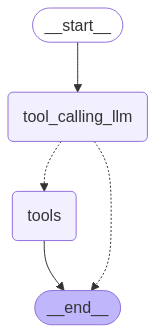

In [ ]:
graph

In [ ]:
user_input = "Explain AI in 2 bullets"
for event in graph.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Explain AI in 2 bullets
================================== Ai Message ==================================

- **Machine Learning and Algorithms**: AI involves the use of machine learning algorithms and models that enable computers to learn from data, identify patterns, and make decisions with minimal human intervention. This includes techniques like neural networks, deep learning, and natural language processing.

- **Automation and Intelligence**: AI aims to automate tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language translation, thereby enhancing efficiency and productivity across various industries.


In [ ]:
user_input = "what are the latest LLMs released in 2025"
for event in graph.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what are the latest LLMs released in 2025
================================== Ai Message ==================================
Tool Calls:
  search_web_extract_info (call_QlsOLlDrLFSF3n259Y5U4OfG)
 Call ID: call_QlsOLlDrLFSF3n259Y5U4OfG
  Args:
    query: latest LLMs released in 2025
================================= Tool Message =================================
Name: search_web_extract_info

["## Title\n\nBest 39 Large Language Models (LLMs) in 2025 - Exploding Topics\n\n## Content\n\nBest 22 Large Language Models (LLMs) (February 2025)\n\n\n\nAbout\nNewsletter\nBlog\n\n\nBest 22 Large Language Models (LLMs) (February 2025)\n\nby Anthony Cardillo\nFebruary 7, 2025\nLarge language models are pre-trained on large datasets and use natural language processing to perform linguistic tasks such as text generation, code completion, paraphrasing, and more.\nThe initial release of ChatGPT sparked the rapid adoption o

In [ ]:
user_input = "how's the weather in berlin"
for event in graph.stream({"messages": user_input},
                          stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

how's the weather in berlin
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_oqvJDRwMAIH6RZRH2TmMCUGy)
 Call ID: call_oqvJDRwMAIH6RZRH2TmMCUGy
  Args:
    query: Berlin
================================= Tool Message =================================
Name: get_weather

{"location": {"name": "Berlin", "region": "Berlin", "country": "Germany", "lat": 52.5167, "lon": 13.4, "tz_id": "Europe/Berlin", "localtime_epoch": 1741507521, "localtime": "2025-03-09 09:05"}, "current": {"last_updated_epoch": 1741507200, "last_updated": "2025-03-09 09:00", "temp_c": 5.2, "temp_f": 41.4, "is_day": 1, "condition": {"text": "Sunny", "icon": "//cdn.weatherapi.com/weather/64x64/day/113.png", "code": 1000}, "wind_mph": 5.8, "wind_kph": 9.4, "wind_degree": 88, "wind_dir": "E", "pressure_mb": 1009.0, "pressure_in": 29.8, "precip_mm": 0.0, "precip_in": 0.0, "humidity":

In [ ]:
event

{'messages': [HumanMessage(content="how's the weather in berlin", additional_kwargs={}, response_metadata={}, id='338aa7fa-a30a-4978-9bbf-fc13a89216c0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oqvJDRwMAIH6RZRH2TmMCUGy', 'function': {'arguments': '{"query":"Berlin"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 84, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e6ff4880-2adf-448c-808c-c3729556be32-0', tool_calls=[{'name': 'get_weather', 'args': {'query': 'Berlin'}, 'id': 'call_oqvJDRwMAIH6RZRH2TmMCUGy', 'type': 'tool_call'}], usage_metadata={'input_tokens